In [59]:
%load_ext autoreload
%autoreload all

import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from gem import GeodataPointsRegions, MiniFranceTIFData, MiniFranceDataset

sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

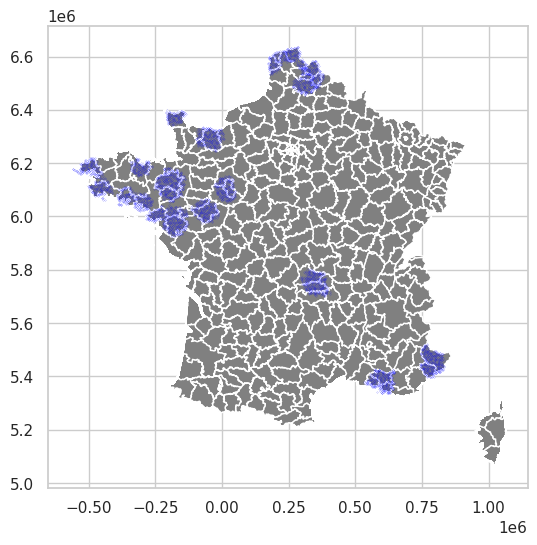

In [60]:
shp_path = "/GEM/files/france_shape/gy606rg8152.shp"
data_dir = "/GEM/data/MiniFrance"

france_map_geo = gpd.read_file(shp_path)
minifrance_data = MiniFranceTIFData(data_dir)
minifrance_geo = minifrance_data.read_geodata()

france_map_geo.to_crs(minifrance_geo.crs, inplace=True)
base = france_map_geo.plot(color='gray', edgecolor='white')
minifrance_geo.plot(ax=base, marker='o', color='blue', markersize=0.01)

In [61]:
france_map_geo.head()

,id_0,iso,name_0,id_1,name_1,id_2,name_2,id_3,name_3,ccn_3,cca_3,type_3,engtype_3,nl_name_3,varname_3,geometry
0,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,1.0,Haguenau,0.0,None,Arrondissement,Districts,None,None,"POLYGON ((857540.757 6263979.952, 859063.924 6..."
1,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,2.0,Molsheim,0.0,None,Arrondissement,Districts,None,None,"POLYGON ((814557.137 6214802.680, 815679.540 6..."
2,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,3.0,Sélestat-Erstein,0.0,None,Arrondissement,Districts,None,None,"MULTIPOLYGON (((856665.659 6186677.636, 856632..."
3,79.0,FRA,France,1.0,Alsace,2.0,Haut-Rhin,13.0,Thann,0.0,None,Arrondissement,Districts,None,None,"POLYGON ((777181.394 6108422.513, 777364.896 6..."
4,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,4.0,Saverne,0.0,None,Arrondissement,Districts,None,None,"POLYGON ((792044.734 6286847.704, 791849.660 6..."


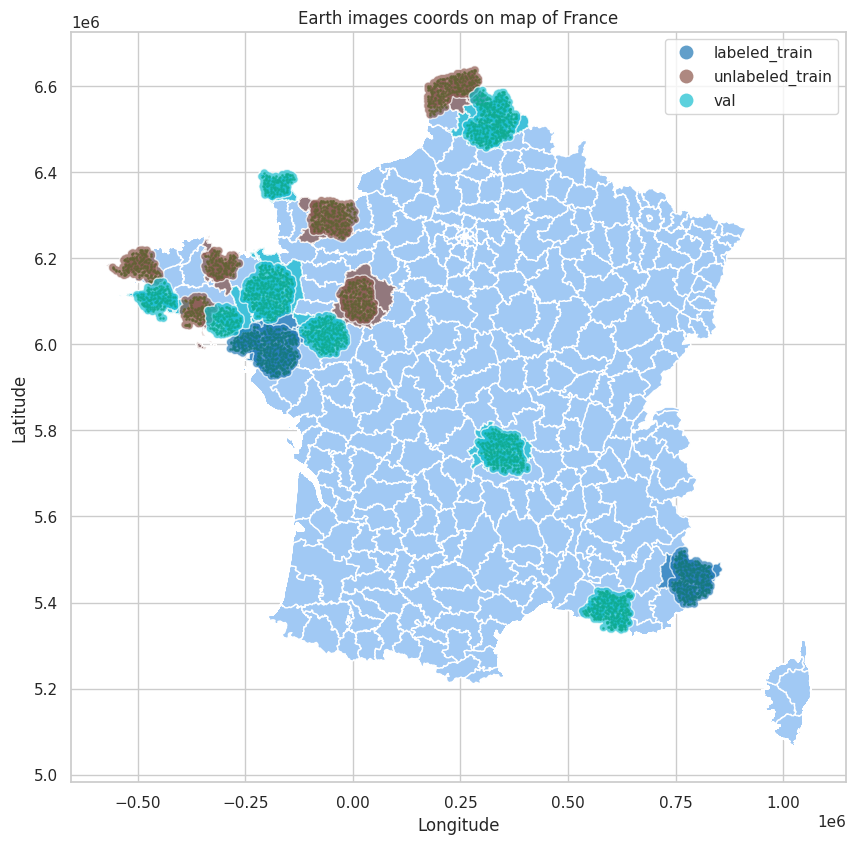

In [62]:
geodata_regions = GeodataPointsRegions(minifrance_geo, france_map_geo)
regions_coverage_geo = geodata_regions.get_regions_coverage()
intersecting_regions_geo = geodata_regions.get_interseting_regions(regions_coverage_geo)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

france_map_geo.plot(ax=ax, alpha=1)
intersecting_regions_geo.plot(ax=ax, column="data_type", alpha=0.7)
minifrance_geo.plot(ax=ax, color="green", alpha=0.7, markersize=1)
regions_coverage_geo.plot(ax=ax, column="data_type", alpha=0.7, legend=True)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Earth images coords on map of France")
plt.show()


Current memory usage: 4866.36328125 MB
0 torch.Size([4, 3, 2000, 2000]) torch.Size([4, 1000, 1000]) torch.Size([4, 1, 2000, 2000])
Current memory usage: 4912.62109375 MB


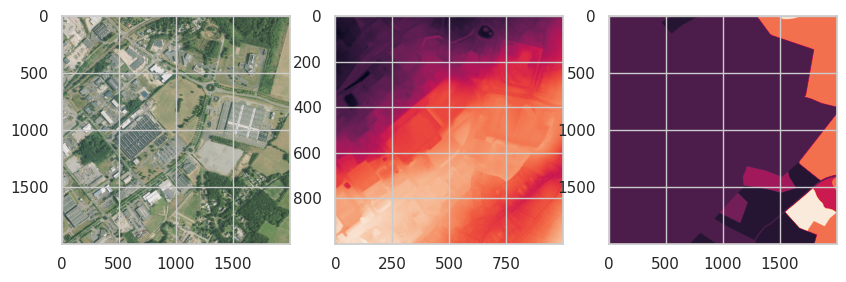

In [63]:
import memory_profiler
import torch

def print_memory_usage():
    current_mem_usage = memory_profiler.memory_usage()[0]
    print(f"Current memory usage: {current_mem_usage} MB")

print_memory_usage()

minifrance_dataset = MiniFranceDataset(minifrance_geo, data_type="labeled_train")
minifrance_loader = torch.utils.data.DataLoader(minifrance_dataset, batch_size=4, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(minifrance_loader):
    print(i_batch, sample_batched["image"].size(), sample_batched["dem"].size(), sample_batched["landcover_map"].size())
    print_memory_usage()
    break

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(sample_batched["image"].to("cpu").numpy()[0].transpose(1, 2, 0))
axarr[1].imshow(sample_batched["dem"].to("cpu").numpy()[0])
axarr[2].imshow(sample_batched["landcover_map"].to("cpu").numpy()[0].transpose(1, 2, 0))

In [64]:
import torch
import torchvision.models as models

# torch.cuda.empty_cache()
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16.eval()
vgg16.to("cpu")

def get_embeddings(batch_imgs):
    batch_imgs = batch_imgs.float()
    with torch.no_grad():
        embeddings = vgg16(batch_imgs)
    return embeddings.cpu().numpy()

In [65]:
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchvision.transforms import transforms

import os
import socket
from datetime import datetime

current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join('/GEM/runs', current_time + '_' + socket.gethostname())

writer = SummaryWriter(log_dir)

transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
    ]
)

def log_embeddings(images, labels, embeddings, step):
    writer.add_embedding(embeddings, metadata=labels, label_img=images, global_step=step)
    grid = make_grid(images, nrow=8, normalize=True)
    writer.add_image("MiniFrance Images", grid, global_step=step)

images = torch.Tensor()
embeddings = torch.Tensor()
labels = []

for i, data in enumerate(minifrance_loader):
    print('start')
    batch_imgs = data["image"]
    batch_labels = data["geodata"]['region']

    batch_embeddings = get_embeddings(batch_imgs)
    batch_imgs = torch.stack([transform(batch_img) for batch_img in batch_imgs])
    print(batch_embeddings.shape, batch_imgs.shape, batch_labels)
    images = torch.cat((images, batch_imgs), dim=0)
    embeddings = torch.cat((embeddings, torch.from_numpy(batch_embeddings)), dim=0)
    labels += batch_labels

    if i % 10 == 0:
        log_embeddings(images, labels, embeddings, i)
        images = torch.Tensor()
        embeddings = torch.Tensor()
        labels = []


start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nice', 'Nice', 'Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nice', 'Nantes_Saint-Nazaire', 'Nice', 'Nice']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nice', 'Nice', 'Nice', 'Nantes_Saint-Nazaire']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nice', 'Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nice', 'Nice', 'Nantes_Saint-Nazaire', 'Nice']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire', 'Nice', 'Nantes_Saint-Nazaire']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire', 'Nice', 'Nantes_Saint-Nazaire']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nice', 'Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire']
start
(4, 1000) torch.Size([4, 3, 100, 100]) ['Nantes_Saint-Nazaire', 'Nantes_Saint-Nazaire', 'Nice', 'N

KeyboardInterrupt: 